### Recurent Neural Network for MNIST digit prediction

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [31]:
random_seed = 77777

In [32]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [33]:
batch_size = 128
num_epochs = 10

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

#### Setup the model

In [110]:
torch.manual_seed(random_seed)

In [111]:
class RNN(nn.Module):
    def __init__(self, num_features, num_hidden, num_hidden_layers, num_output):
        super(RNN, self).__init__()        
        self.num_hidden = num_hidden
        self.num_hidden_layers = num_hidden_layers
        
        self.rnn = nn.RNN(num_features, num_hidden, 
                          num_layers=num_hidden_layers, 
                          batch_first=True, #input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
                          nonlinearity='relu')

        self.linear_out = nn.Linear(num_hidden, num_output)
    
    def forward(self, inputs):
        h0 = torch.zeros(self.num_hidden_layers, inputs.size(0), self.num_hidden) # zero vector hidden state            
        output, hidden = self.rnn(inputs, h0)        
        # Get only hidden state of last time step --> the goal is to get the final prediction to know what digit it is
        output = self.linear_out(output[:, -1, :]) # output.size() --> 128, 10
        
        return output

In [112]:
learning_rate = 0.01
num_epochs = 3

num_features = 28
num_hidden = 100
num_hidden_layers = 2
num_output = 10

#### Loss function, model, optimizer

In [113]:
model = RNN(num_features, num_hidden, num_hidden_layers, num_output)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [114]:
# Number of steps to unroll
seq_dim = 28

#### Train and test the model

In [115]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        outputs = model(images.view(-1, seq_dim, num_features))
        loss = loss_function(outputs, labels)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(images)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [116]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            outputs = model(images.view(-1, seq_dim, num_features))
            test_loss += loss_function(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        accuracy = 100 * correct / total

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}. Accuracy: {}'.format(test_loss, accuracy))

#### Train model and evaluate on test set while it is training

In [117]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.017964
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.004676
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.005399
====> Epoch: 1 Average loss: 0.0071
====> Test set loss: 0.0047. Accuracy: 81
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.004119
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.003240
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.003839
====> Epoch: 2 Average loss: 0.0040
====> Test set loss: 0.0044. Accuracy: 82
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.003488
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.003391
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.003729
====> Epoch: 3 Average loss: 0.0037
====> Test set loss: 0.0031. Accuracy: 88


#### Inspect one image to check

The prediction is: 3
The real value is: 3


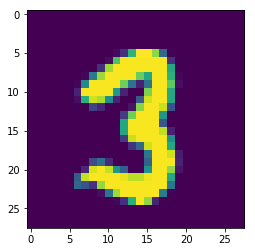

In [152]:
for i, (images, labels) in enumerate(test_loader):
    pass

img = images.data.numpy()[2]
plt.imshow(img.reshape((28, 28)))
out = model(images[2].view(-1, seq_dim, num_features))
__, pred = torch.max(out.data, 1)

print("The prediction is: "+str(pred.item()))
print("The real value is: "+str(labels.data.numpy()[2]))